In [0]:
'''
# mounts Google Drive to the Colab VM
from google.colab import drive, files
drive.mount('/content/drive', force_remount=True)

# project github foldername
FOLDERNAME = '/content/drive/My Drive/CS231N/Project/RainfallNowcasting/MovingMNIST/'

# load python files from foldername
import sys
sys.path.append(FOLDERNAME)

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2
'''

In [1]:
# Useful libraries
import numpy as np
import math as ma
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from google.colab import files
import csv
%matplotlib inline
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 3

# Download Moving-MNIST dataset
!wget 'http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy'

--2020-05-20 23:34:05--  http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 819200096 (781M)
Saving to: ‘mnist_test_seq.npy’

mnist_test_seq.npy  100%[===================>] 781.25M  48.1MB/s    in 16s     

2020-05-20 23:34:22 (47.4 MB/s) - ‘mnist_test_seq.npy’ saved [819200096/819200096]



In [0]:
#
# Parameters
#
loss = 'binary_crossentropy'
optimizer = tf.keras.optimizers.Adam(lr=5e-4)
activ = 'relu'
init = 'he_normal'
nk = 128
ks = 5
lks = 3
#
Ninput = 10
Noutput = 10
Nsample = 500
bs = 8
ep = 20

In [4]:
#
# Data processing
#
def split_data(dataset, n):
  data = np.load(dataset, mmap_mode='r')
  train = data[:, :n, :, :]
  test = data[:, n:n+n//10, :, :]
  return train, test
def preprocess(data):
  data = data.swapaxes(0, 1) # swap frames and instances for tf handling
  data = np.expand_dims(data, -1) # add channel dimension for tf handling (channel=1, ie grayscale)
  data = data/np.amax(data) # minmax normalize data
  data = tf.cast(data, tf.float32) # convert to float32 for tf handling
  return data
def make_XY(data, Ninput, Noutput):
  X = data[:, :Ninput, :, :, :]
  y = data[:, Ninput, :, :, :]
  return X, y
data_train, data_test = split_data('mnist_test_seq.npy', Nsample)
data_train = preprocess(data_train)
data_test = preprocess(data_test)
N, F, H, W, C = data_train.shape
X, y = make_XY(data_train, Ninput, Noutput)
Xtest, ytest = make_XY(data_test, Ninput, Noutput)
print('data_train (instance, frame, height, width, channel) = '+str(data_train.shape))
print('data_test (instance, frame, height, width, channel) = '+str(data_test.shape))

data_train (instance, frame, height, width, channel) = (500, 20, 64, 64, 1)
data_test (instance, frame, height, width, channel) = (50, 20, 64, 64, 1)


In [0]:
# Model Architecture
def model_init(): 
    layers = [tf.keras.layers.ConvLSTM2D(nk, ks, padding='same', activation=activ, kernel_initializer=init, return_sequences=True),
              tf.keras.layers.ConvLSTM2D(nk, ks, padding='same', activation=activ, kernel_initializer=init, return_sequences=True),
              tf.keras.layers.ConvLSTM2D(nk, ks, padding='same', activation=activ, kernel_initializer=init, return_sequences=True),
              tf.keras.layers.ConvLSTM2D(nk, ks, padding='same', activation=activ, kernel_initializer=init),
              tf.keras.layers.Conv2D(1, lks, padding='same', bias_initializer=tf.keras.initializers.Constant(value=-np.log(99)), activation='sigmoid')]
    return tf.keras.Sequential(layers)

In [0]:
# Custom metrics

def ssim(y_gt, y_pred, max_val=1.):
  return tf.image.ssim(y_gt, y_pred, max_val)

def psnr(y_gt, y_pred, max_val=1.):
  return tf.image.psnr(y_gt, y_pred, max_val)

def cor(y_gt, y_pred):
  return tfp.stats.correlation(y_gt, y_pred, sample_axis=None, event_axis=None)

In [7]:
# Initialize model
model = model_init()

# Build optimizer
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['acc', 'mse', ssim, psnr, cor,
                       tf.keras.metrics.Precision(name='prec'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.FalseNegatives(name='FN'), 
                       tf.keras.metrics.FalsePositives(name='FP'),
                       tf.keras.metrics.TrueNegatives(name='TN'), 
                       tf.keras.metrics.TruePositives(name='TP')])

# Fit the model
csv_logger = tf.keras.callbacks.CSVLogger('train_results.csv')
history = model.fit(X, y, 
                    batch_size=bs, epochs=ep, 
                    callbacks=[csv_logger],
                    validation_split=0.1)
#files.download('training_results.csv')

# Save it
#model.save('model.h5')
#files.download('model.h5')

# Get results on test set
results = model.evaluate(Xtest, ytest, batch_size=bs, return_dict=True)
with open('test_results.csv', 'w') as f:
    w = csv.DictWriter(f, results.keys())
    w.writeheader()
    w.writerow(results)
#files.download('test_results.csv')

Epoch 1/20
57/57 [==============================] - 122s 2s/step - loss: 0.2063 - acc: 0.9237 - mse: 0.0383 - ssim: 0.1780 - psnr: 14.4771 - cor: 0.3139 - prec: 0.5110 - recall: 0.0692 - FN: 122915.0000 - FP: 8752.0000 - TN: 1702389.0000 - TP: 9144.0000 - val_loss: 0.1041 - val_acc: 0.9292 - val_mse: 0.0243 - val_ssim: 0.4040 - val_psnr: 16.2579 - val_cor: 0.6179 - val_prec: 0.7597 - val_recall: 0.1764 - val_FN: 11452.0000 - val_FP: 776.0000 - val_TN: 190119.0000 - val_TP: 2453.0000
Epoch 2/20
57/57 [==============================] - 121s 2s/step - loss: 0.0889 - acc: 0.9227 - mse: 0.0216 - ssim: 0.6739 - psnr: 16.8031 - cor: 0.6858 - prec: 0.7880 - recall: 0.3412 - FN: 87004.0000 - FP: 12120.0000 - TN: 1699021.0000 - TP: 45055.0000 - val_loss: 0.0830 - val_acc: 0.9298 - val_mse: 0.0199 - val_ssim: 0.7338 - val_psnr: 17.1609 - val_cor: 0.7055 - val_prec: 0.8298 - val_recall: 0.3079 - val_FN: 9623.0000 - val_FP: 878.0000 - val_TN: 190017.0000 - val_TP: 4282.0000
Epoch 3/20
57/57 [======

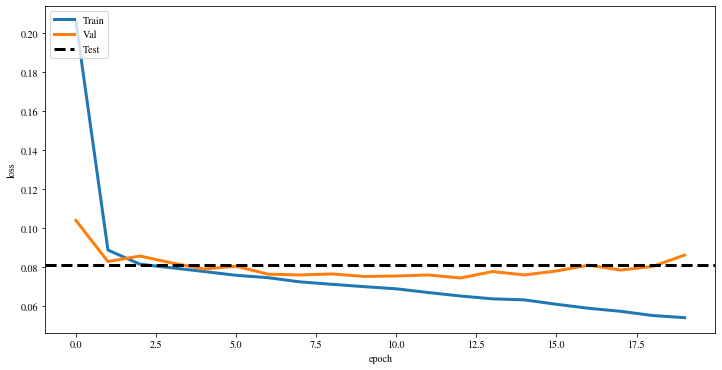

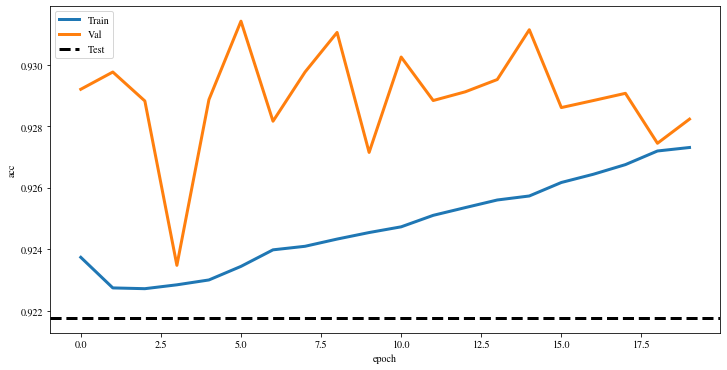

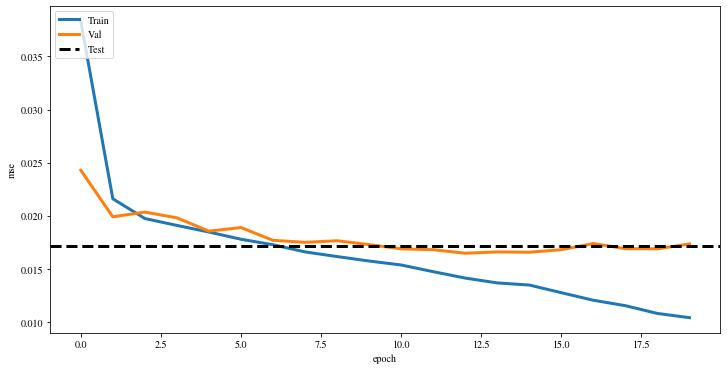

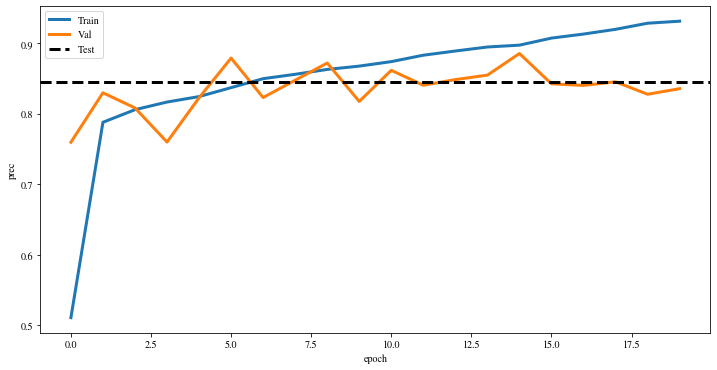

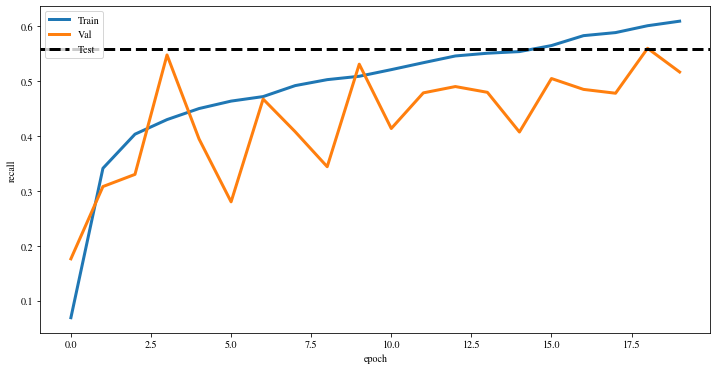

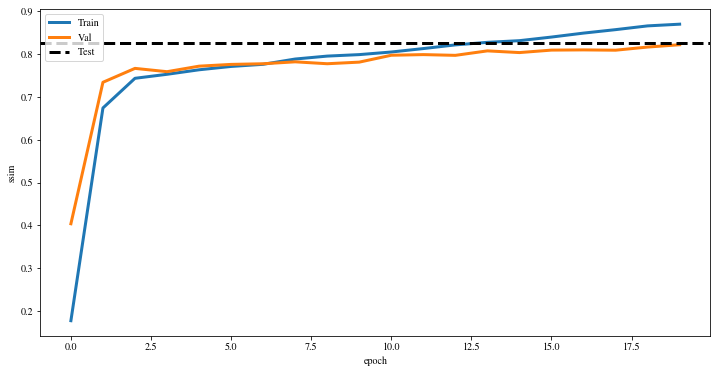

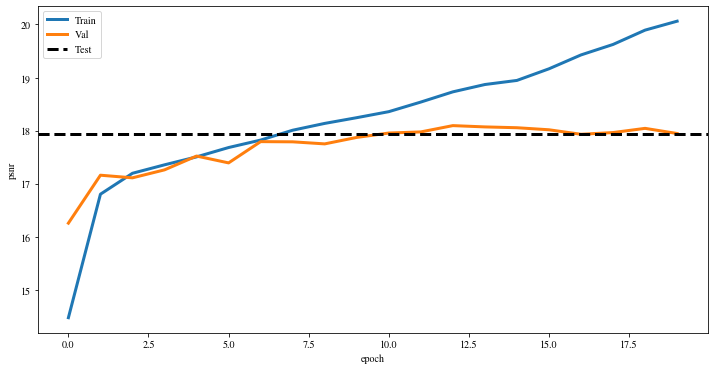

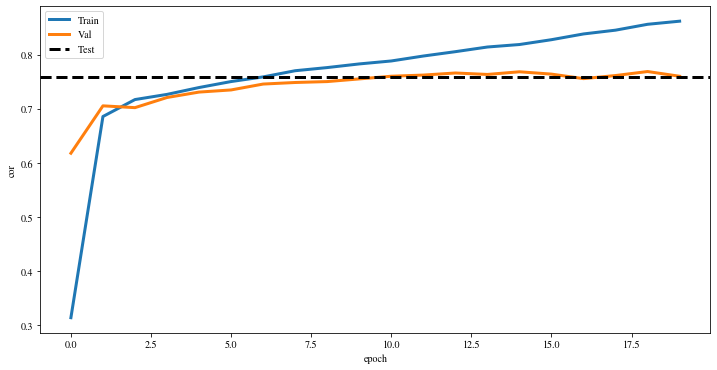

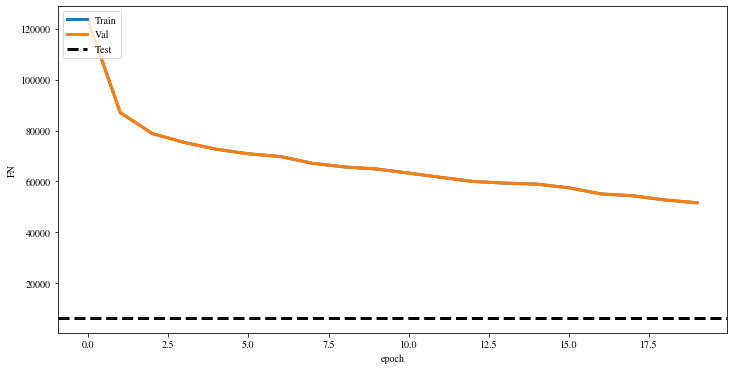

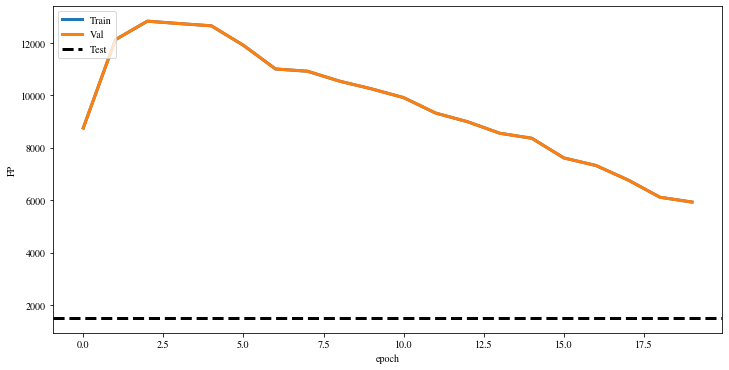

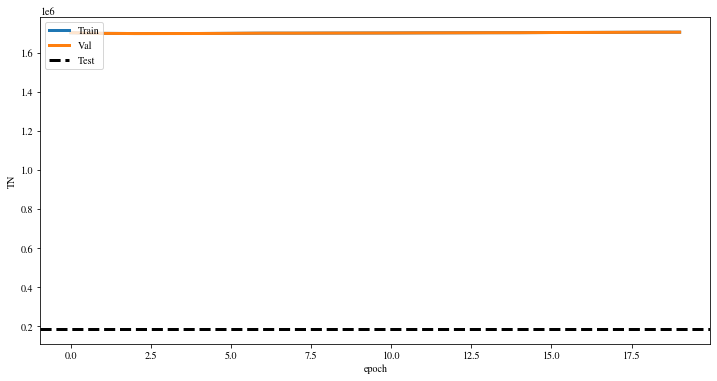

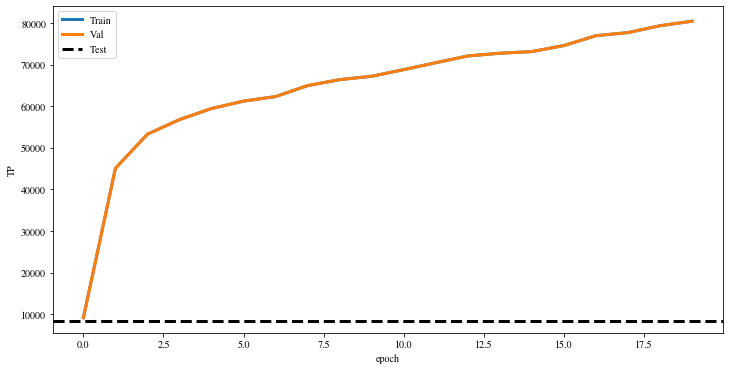

In [8]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.axhline(results['loss'], linestyle='--', color='k', label='Test')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss.png')
#files.download('loss.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['acc'], label='Train')
plt.plot(history.history['val_acc'], label='Val')
plt.axhline(results['acc'], linestyle='--', color='k', label='Test')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('acc.png')
#files.download('acc.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['mse'], label='Train')
plt.plot(history.history['val_mse'], label='Val')
plt.axhline(results['mse'], linestyle='--', color='k', label='Test')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('mse.png')
#files.download('mse.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['prec'], label='Train')
plt.plot(history.history['val_prec'], label='Val')
plt.axhline(results['prec'], linestyle='--', color='k', label='Test')
plt.ylabel('prec')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('prec.png')
#files.download('prec.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['recall'], label='Train')
plt.plot(history.history['val_recall'], label='Val')
plt.axhline(results['recall'], linestyle='--', color='k', label='Test')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('recall.png')
#files.download('recall.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['ssim'], label='Train')
plt.plot(history.history['val_ssim'], label='Val')
plt.axhline(results['ssim'], linestyle='--', color='k', label='Test')
plt.ylabel('ssim')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('ssim.png')
#files.download('ssim.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['psnr'], label='Train')
plt.plot(history.history['val_psnr'], label='Val')
plt.axhline(results['psnr'], linestyle='--', color='k', label='Test')
plt.ylabel('psnr')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('psnr.png')
#files.download('psnr.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['cor'], label='Train')
plt.plot(history.history['val_cor'], label='Val')
plt.axhline(results['cor'], linestyle='--', color='k', label='Test')
plt.ylabel('cor')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('cor.png')
#files.download('cor.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['FN'], label='Train')
plt.plot(history.history['FN'], label='Val')
plt.axhline(results['FN'], linestyle='--', color='k', label='Test')
plt.ylabel('FN')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('FN.png')
#files.download('FN.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['FP'], label='Train')
plt.plot(history.history['FP'], label='Val')
plt.axhline(results['FP'], linestyle='--', color='k', label='Test')
plt.ylabel('FP')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('FP.png')
#files.download('FP.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['TN'], label='Train')
plt.plot(history.history['TN'], label='Val')
plt.axhline(results['TN'], linestyle='--', color='k', label='Test')
plt.ylabel('TN')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('TN.png')
#files.download('TN.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['TP'], label='Train')
plt.plot(history.history['TP'], label='Val')
plt.axhline(results['TP'], linestyle='--', color='k', label='Test')
plt.ylabel('TP')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('TP.png')
#files.download('TP.png')

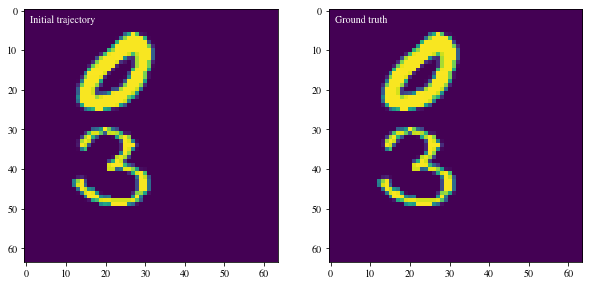

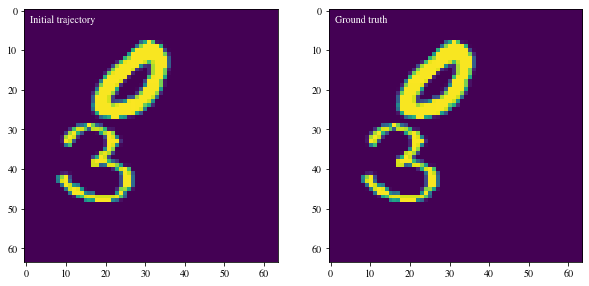

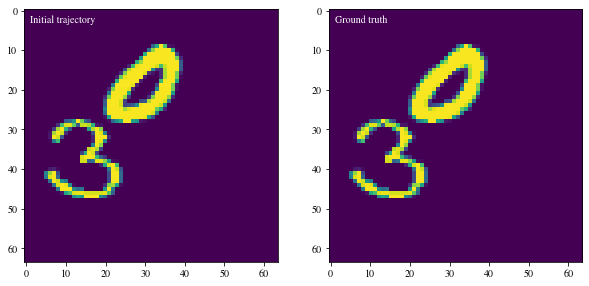

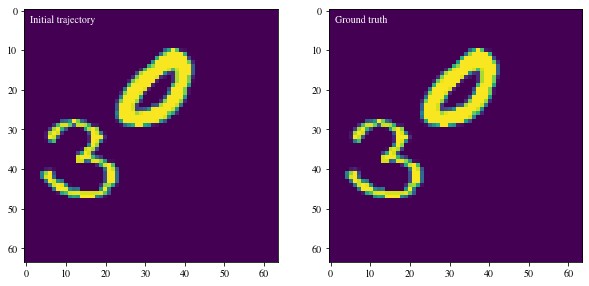

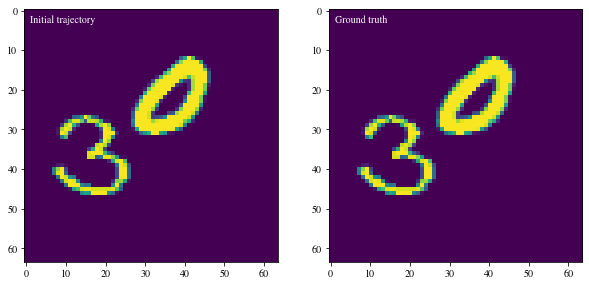

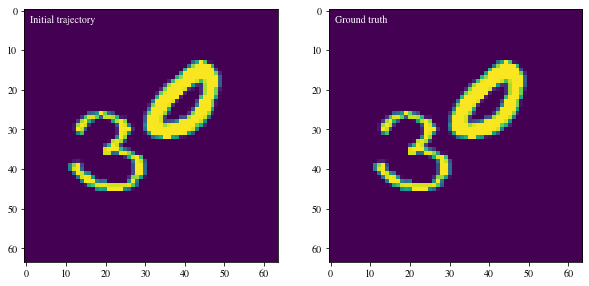

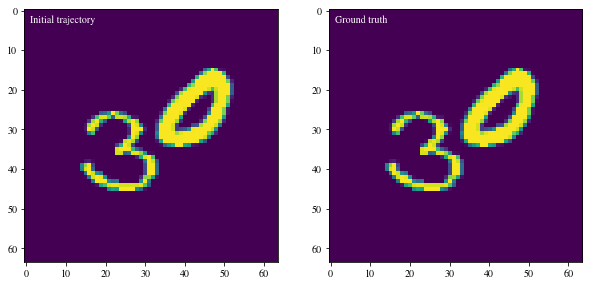

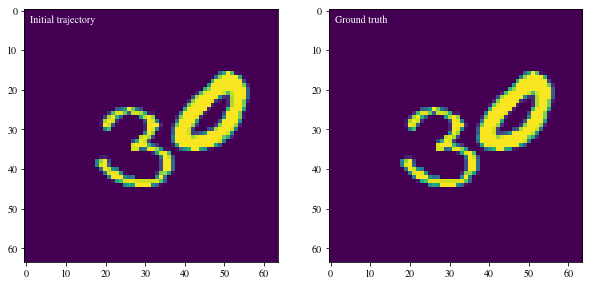

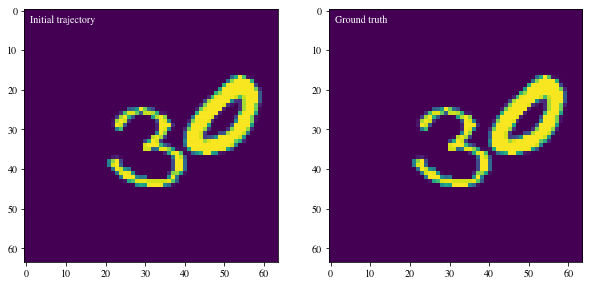

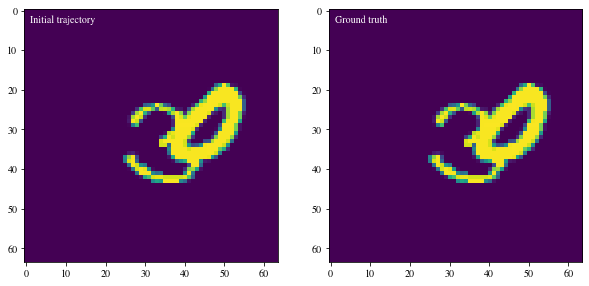

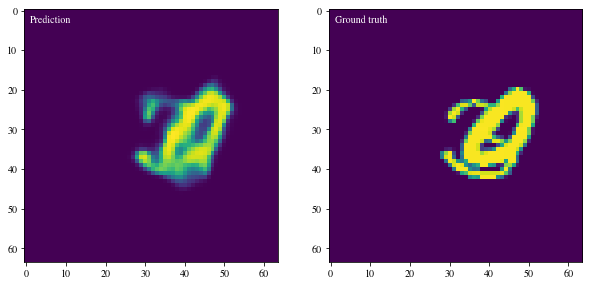

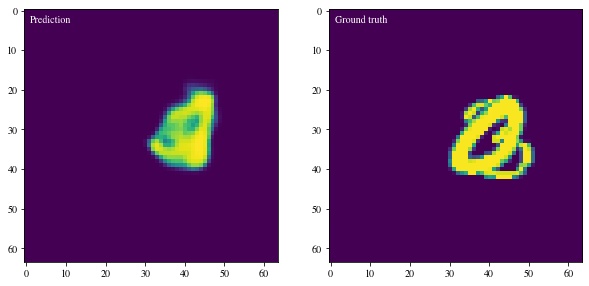

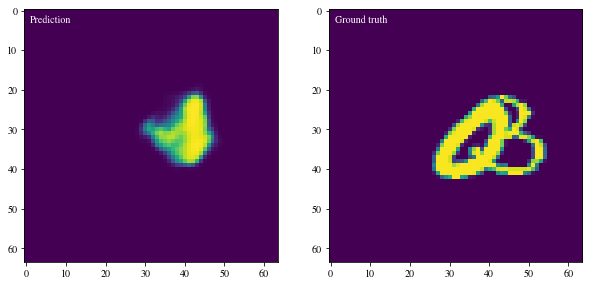

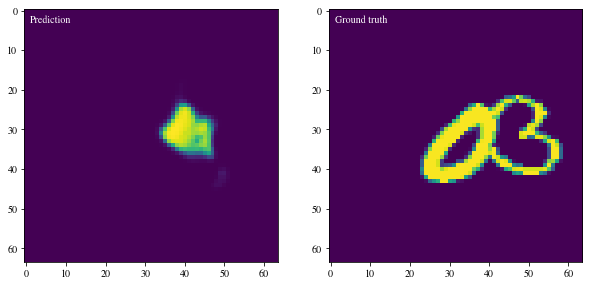

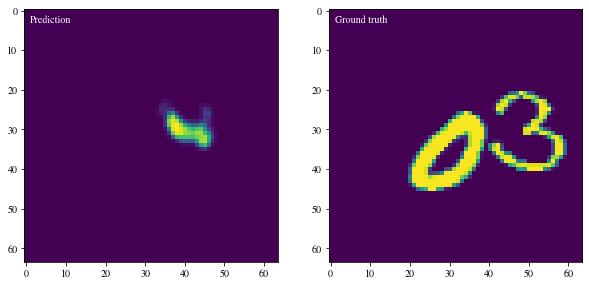

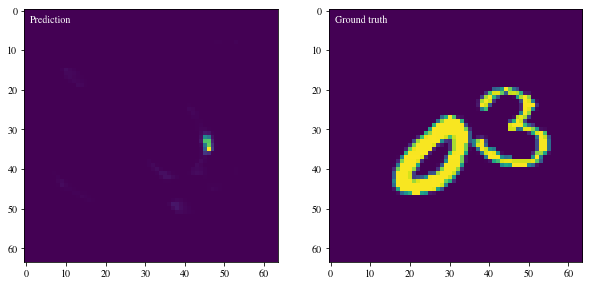

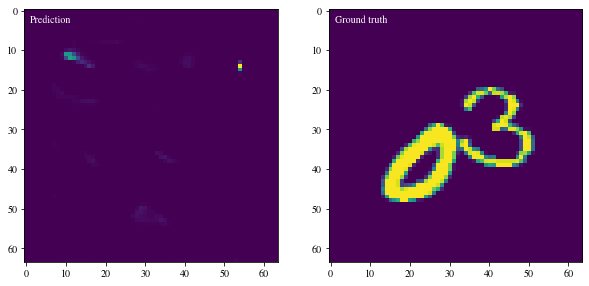

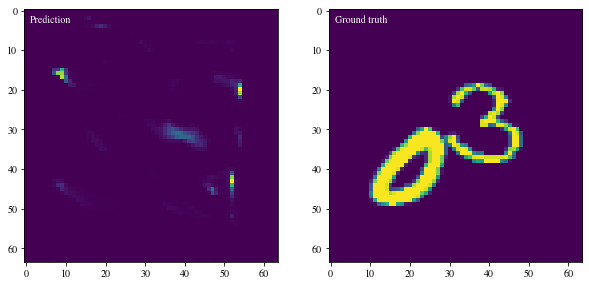

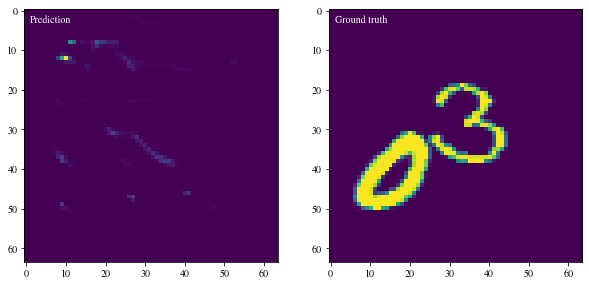

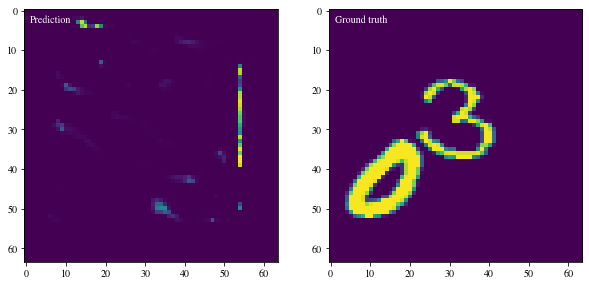

In [11]:
# Plot Train
itest = 1
track = X[itest, :, :, :, :]
for i in range(Noutput):
  new_pos = model.predict(track[None, :, :, :, :])
  track = np.concatenate((track, new_pos), axis=0)
true_track = data_train[itest, :, :, :, :]
for i in range(Ninput+Noutput):
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    if i >= Ninput:
        plt.text(1, 3, 'Prediction', color='w')
    else:
        plt.text(1, 3, 'Initial trajectory', color='w')
    plt.imshow(track[i, :, :, 0])
    plt.subplot(122)
    plt.text(1, 3, 'Ground truth', color='w')
    plt.imshow(true_track[i, :, :, 0])
    plt.savefig('train_%i.png' % (i+1))
    #files.download('train_%i.png' % (i+1))

In [0]:
# Plot Test
itest = 1
track = Xtest[itest, :, :, :, :]
for i in range(Noutput):
  new_pos = model.predict(track[None, :, :, :, :])
  track = np.concatenate((track, new_pos), axis=0)
true_track = data_test[itest, :, :, :, :]
for i in range(Ninput+Noutput):
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    if i >= Ninput:
        plt.text(1, 3, 'Prediction', color='w')
    else:
        plt.text(1, 3, 'Initial trajectory', color='w')
    plt.imshow(track[i, :, :, 0])
    plt.subplot(122)
    plt.text(1, 3, 'Ground truth', color='w')
    plt.imshow(true_track[i, :, :, 0])
    plt.savefig('test_%i.png' % (i+1))
    #files.download('test_%i.png' % (i+1))